# ADMM Optimizer

## Introduction

The ADMM Optimizer can solve classes of mixed-binary constrained optimization problems, hereafter (MBCO), which often appear in logistic, finance, and operation research. In particular, the ADMM Optimizer here designed can tackle the following optimization problem $(P)$:

$$
\min_{x \in \mathcal{X},u\in\mathcal{U} \subseteq \mathbb{R}^l } \quad q(x) + \varphi(u),
$$

subject to the constraints:

$$
\mathrm{s.t.:~} \quad G x = b, \quad  g(x) \leq 0, \quad \ell(x, u) \leq 0, 
$$

with the corresponding functional assumptions.

1. Function $q: \mathbb{R}^n \to \mathbb{R}$ is quadratic, i.e., $q(x) = x^{\intercal} Q x + a^{\intercal} x$ for a given symmetric squared matrix $Q \in \mathbb{R}^n \times \mathbb{R}^n, Q = Q^{\intercal}$, and vector $a \in \mathbb{R}^n$;
2. The set $\mathcal{X} = \{0,1\}^n = \{x_{(i)} (1-x_{(i)}) = 0, \forall i\}$ enforces the binary constraints;
3. Matrix $G\in\mathbb{R}^n \times \mathbb{R}^{n'}$, vector $b \in \mathbb{R}^{n'}$, and function $g: \mathbb{R}^n \to \mathbb{R}$ is convex;
4. Function $\varphi: \mathbb{R}^l \to \mathbb{R}$ is convex and $\mathcal{U}$ is a convex set;
5. Function $\ell: \mathbb{R}^n\times  \mathbb{R}^l \to \mathbb{R}$ is *jointly* convex in $x, u$.

In order to solve MBO problems, [1] proposed heuristics for $(P)$ based on the Alternating Direction Method of Multipliers (ADMM) [2]. ADMM is an operator splitting algorithm with a long history in convex optimization, and it is known to have residual, objective and dual variable convergence properties, provided that convexity assumptions are holding.

The method of [1] (referred to as 3-ADMM-H) leverages the ADMM operator-splitting procedure to devise a decomposition for certain classes of MBOs into:
- a QUBO subproblem to be solved by on the quantum device via variational algorithms, such as VQE or QAOA;
- continuous convex constrained subproblem, which can be efficiently solved with classical optimization solvers.

The algorithm 3-ADMM-H works as follows:

0. Initialization phase (set the parameters and the QUBO and convex solvers);
1. For each ADMM iterations ($k = 1, 2, \ldots, $) until termination:
    - Solve a properly defined QUBO subproblem (with a classical or quantum solver);
    - Solve properly defined convex problems (with a classical solver);
    - Update the dual variables.
2. Return optimizers and cost.

    
A comprehensive discussion on the conditions for convergence, feasibility and optimality of the algorithm can be found in [1]. A variant with 2 ADMM blocks, namely a QUBO subproblem, and a continuous convex constrained subproblem, is also introduced in [1].

## References

[1] [C. Gambella and A. Simonetto, *Multi-block ADMM  heuristics  for  mixed-binary  optimization, on  classical  and  quantum  computers,*  arXiv  preprint arXiv:2001.02069  (2020).](https://arxiv.org/abs/2001.02069)

[2] [S. Boyd, N. Parikh, E. Chu, B. Peleato, and J. Eckstein, *Distributed  optimization  and statistical learning via the alternating direction method of  multipliers,*  Foundations  and  Trends in  Machine learning, 3, 1–122 (2011).](https://web.stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf)

## Initialization
First of all we load all the packages that we need.

In [1]:
import time
from typing import List, Optional, Any
import numpy as np
import matplotlib.pyplot as plt 

from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram
from qiskit.optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer

# If CPLEX is installed, you can uncomment this line to import the CplexOptimizer.
# CPLEX can be used in this tutorial to solve the convex continuous problem, 
# but also as a reference to solve the QUBO, or even the full problem.
# 
# from qiskit.optimization.algorithms import CplexOptimizer

We first initialize all the algorithms we plan to use later in this tutorial.

To solve the QUBO problems we can choose between 
- `MinimumEigenOptimizer` using different `MinimumEigensolver`, such as `VQE`, `QAOA` or `NumpyMinimumEigensolver` (classical)
- `GroverOptimizer`
- `CplexOptimizer` (classical, if CPLEX is installed)

and to solve the convex continuous problems we can choose between the following classical solvers:
- `CplexOptimizer` (if CPLEX is installed)
- `CobylaOptimizer`

In case CPLEX is not available, the `CobylaOptimizer` (for convex continuous problems) and the `MinimumEigenOptimizer` using the `NumpyMinimumEigensolver` (for QUBOs) can be used as classical alternatives to CPLEX for testing, validation, and benchmarking.

In [2]:
# define COBYLA optimizer to handle convex continuous problems.
cobyla = CobylaOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend('statevector_simulator')))

# exact QUBO solver as classical benchmark
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver()) # to solve QUBOs

# in case CPLEX is installed it can also be used for the convex problems, the QUBO, 
# or as a benchmark for the full problem.
#
# cplex = CplexOptimizer()

## Example

We test 3-ADMM-H algorithm on a simple Mixed-Binary Quadratic Problem with equality and inequality constraints (Example 6 reported in [1]). We first construct a docplex problem and then load it into a `QuadraticProgram`.

In [3]:
# construct model using docplex
mdl = Model('ex6')

v = mdl.binary_var(name='v')
w = mdl.binary_var(name='w')
t = mdl.binary_var(name='t')
u = mdl.continuous_var(name='u')

mdl.minimize(v + w + t + 5 * (u-2)**2)
mdl.add_constraint(v + 2 * w + t + u <= 3, "cons1")
mdl.add_constraint(v + w + t >= 1, "cons2")
mdl.add_constraint(v + w == 1, "cons3")

# load quadratic program from docplex model
qp = QuadraticProgram()
qp.from_docplex(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: ex6

Minimize
 obj: v + w + t - 20 u + [ 10 u^2 ]/2 + 20
Subject To
 cons1: v + 2 w + t + u <= 3
 cons2: v + w + t >= 1
 cons3: v + w = 1

Bounds
 0 <= v <= 1
 0 <= w <= 1
 0 <= t <= 1

Binaries
 v w t
End



## Classical Solution

3-ADMM-H needs a QUBO optimizer to solve the QUBO subproblem, and a continuous optimizer to solve the continuous convex constrained subproblem. We first solve the problem classically: we use the `MinimumEigenOptimizer` with the `NumPyMinimumEigenSolver` as a classical and exact QUBO solver and we use the `CobylaOptimizer` as a continuous convex solver. 3-ADMM-H supports any other suitable solver available in Qiskit. For instance, VQE, QAOA, and GroverOptimizer can be invoked as quantum solvers, as demonstrated later.
If CPLEX is installed, the `CplexOptimizer` can also be used as both, a QUBO and convex solver.

### Parameters
The 3-ADMM-H are wrapped in class `ADMMParameters`. Customized parameter values can be set as arguments of the class. In this example, parameters $\rho, \beta$ are initialized to $1001$ and $1000$, respectively. The penalization `factor_c` of equality constraints $Gx = b$ is set to $900$. The tolerance `tol` for primal residual convergence is set to `1.e-6`. 
In this case, the 3-block implementation is guaranteed to converge for Theorem 4 of [1], because the inequality constraint with the continuous variable is always active. The 2-block implementation can be run by setting `three_block=False`, and practically converges to a feasible not optimal solution. 


In [4]:
admm_params = ADMMParameters(
                            rho_initial=1001, 
                            beta=1000, 
                            factor_c=900,
                            maxiter=100,
                            three_block=True, tol=1.e-6
                        )

### Calling 3-ADMM-H algorithm
To invoke the 3-ADMM-H algorithm, an instance of the `ADMMOptimizer` class needs to be created. This takes ADMM-specific parameters and the subproblem optimizers separately into the constructor. The solution returned is an instance of `OptimizationResult` class.

In [5]:
# define QUBO optimizer
qubo_optimizer = exact
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params, 
                     qubo_optimizer=qubo_optimizer,
                     continuous_optimizer=convex_optimizer)

In [6]:
# run ADMM to solve problem
result = admm.solve(qp)

### Classical Solver Result
The 3-ADMM-H solution can be then printed and visualized. The `x` attribute of the solution contains respectively, the
values of the binary decision variables and the values of the continuous decision variables. The `fval` is the objective
value of the solution.

In [7]:
print("x={}".format(result.x))
print("fval={:.2f}".format(result.fval))

x=[1. 0. 0. 2.]
fval=1.00


Solution statistics can be accessed in the `state` field and visualized. We here display the convergence of 3-ADMM-H, in terms of primal residuals.

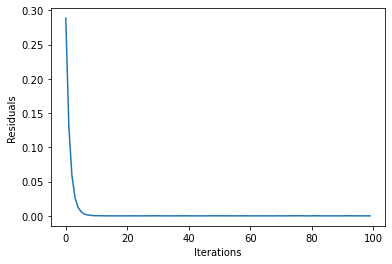

In [8]:
plt.plot(result.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

## Quantum Solution
We now solve the same optimization problem with QAOA as QUBO optimizer, running on simulated quantum device. 
First, one need to select the classical optimizer of the eigensolver QAOA. Then, the simulation backened is set. Finally, 
the eigensolver is wrapped into the `MinimumEigenOptimizer` class. A new instance of `ADMMOptimizer` is populated with QAOA as QUBO optimizer.

In [9]:
# define QUBO optimizer
qubo_optimizer = qaoa 

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with quantum QUBO optimizer and classical convex optimizer
admm_q = ADMMOptimizer(params=admm_params, 
                       qubo_optimizer=qubo_optimizer,
                       continuous_optimizer=convex_optimizer)

In [10]:
# run ADMM to solve problem
result_q = admm_q.solve(qp)

### Quantum Solver Results
Here we present the results obtained from the quantum solver. As in the example above `x` stands for the solution, the `fval` is for objective value.

In [11]:
print("x={}".format(result_q.x))
print("fval={:.2f}".format(result_q.fval))

x=[1. 0. 0. 2.]
fval=1.00


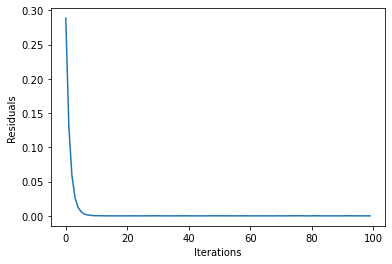

In [12]:
plt.clf()
plt.plot(result_q.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright